# Observing the performance of a solution method to changes to the environment's datarate

In [1]:
import pandas as pd

# Replace 'your_file.csv' with the path to your CSV file
csv_file_path = 'data/SPS_CartPole-v0__dqn__1__1711576443.csv'
df = pd.read_csv(csv_file_path)

print(df.head())


      Wall time   Step    Value
0  1.711576e+09  10600  16437.0
1  1.711576e+09  11900  15103.0
2  1.711576e+09  12500  14593.0
3  1.711576e+09  14100  13555.0
4  1.711576e+09  14300  13451.0


In [2]:
df.columns

Index(['Wall time', 'Step', 'Value'], dtype='object')

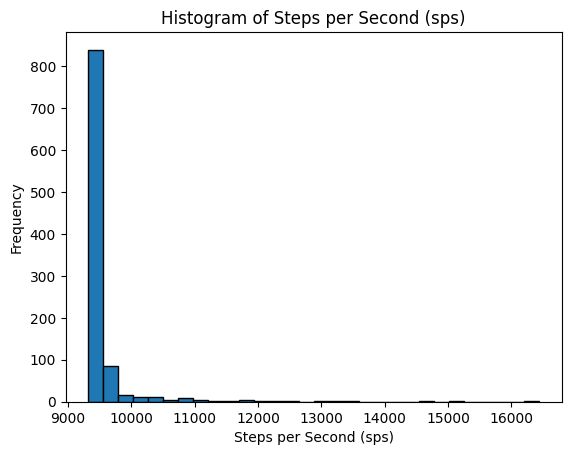

In [3]:
import matplotlib.pyplot as plt

# Create a histogram of the 'Value' column
# Adjust the number of bins as needed
plt.hist(df['Value'], bins=30, edgecolor='k')  

plt.title('Histogram of Steps per Second (sps)')
plt.xlabel('Steps per Second (sps)')
plt.ylabel('Frequency')

plt.show()

Most of the data lies under 9000 sps, so 8500 or so. But it's not a normal distribution, it seemed to be fast at the start but then slowed down toward the end of training. 


My hypothesis is that the experience replay gets filled up to the `buffer_size = 10_000` so once it is full it'll be as fast as it will ever be. 

## Plotting steps-per-second over the course of training

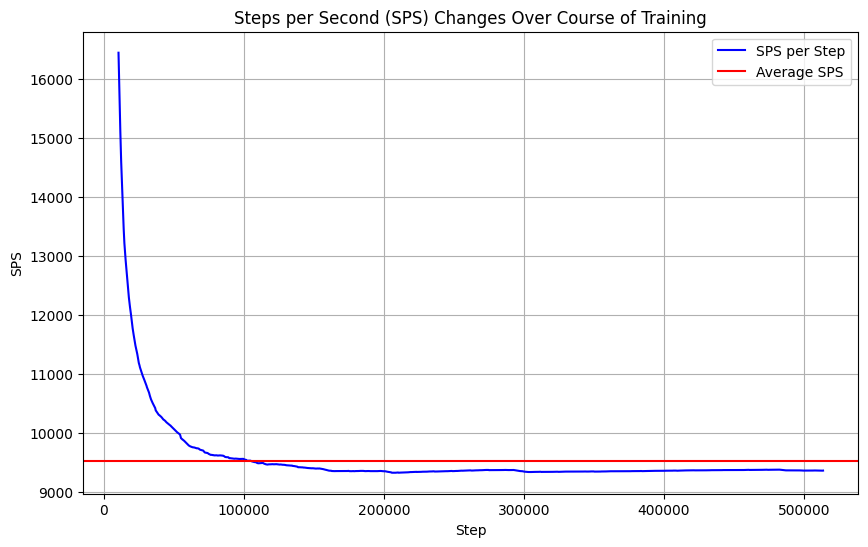

In [4]:
# Compute the average sps
average_sps = df['Value'].mean()

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(df['Step'], df['Value'], label='SPS per Step', color='blue')  # SPS changes over training
plt.axhline(y=average_sps, color='r', linestyle='-', label='Average SPS')  # Average SPS

plt.title('Steps per Second (SPS) Changes Over Course of Training')
plt.xlabel('Step')
plt.ylabel('SPS')
plt.legend()
plt.grid(True)

plt.show()


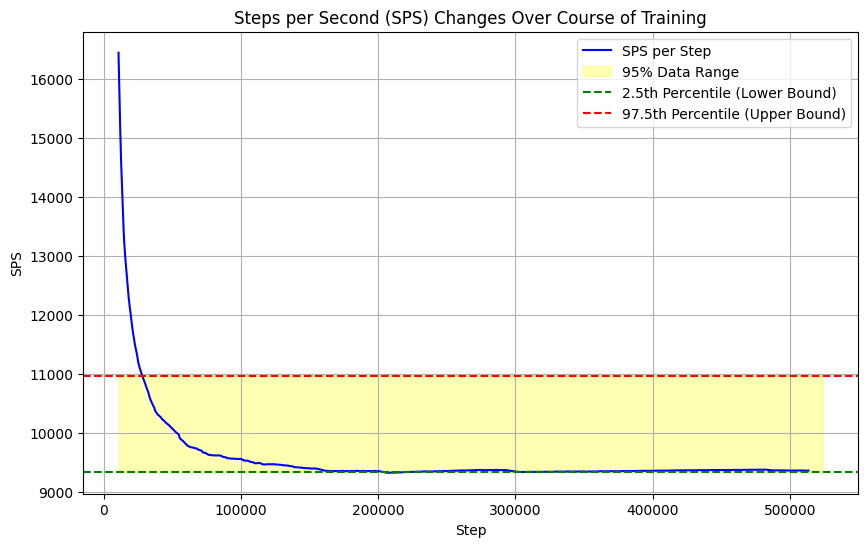

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Assuming 'df' is your DataFrame

# Calculate the 2.5th and 97.5th percentiles
lower_bound = np.percentile(df['Value'], 2.5)
upper_bound = np.percentile(df['Value'], 97.5)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Step'], df['Value'], label='SPS per Step', color='blue')

# Add a patch (rectangle) to highlight the area within the 95% of data
# Note: The rectangle's height is set arbitrarily high to ensure it covers the variability in the SPS range.
plt.gca().add_patch(patches.Rectangle((df['Step'].min(), lower_bound), df['Step'].max(), upper_bound-lower_bound, color='yellow', alpha=0.3, label='95% Data Range'))

plt.axhline(y=lower_bound, color='green', linestyle='--', label='2.5th Percentile (Lower Bound)')
plt.axhline(y=upper_bound, color='red', linestyle='--', label='97.5th Percentile (Upper Bound)')

plt.title('Steps per Second (SPS) Changes Over Course of Training')
plt.xlabel('Step')
plt.ylabel('SPS')
plt.legend()
plt.grid(True)

plt.show()


In [7]:
df['Value'].min(), lower_bound, upper_bound, df['Value'].max()

(9319.0, 9326.0, 10961.724999999999, 16437.0)

# Why is there a exponential decay in performance and then it plateaus?
- One explination could be the epsilon schedule? But it is linear, so I would expect our SPS to linearly get slower.
- Another is the experience replay buffer is filling up, but I expect this to be full and use constant time after 10_000 steps.

# Grab DQN and try different datarates

In [21]:
import pathlib
tb_results_dir = pathlib.Path('runs/')

print(
f"""
There are a bunch of experiments outputted by tensorboard:

{list(tb_results_dir.glob("*"))=}

Inside each of them is:
{list(tb_results_dir.glob("**/*"))}

I would like to pull out the results, and have each row be a step, and each column have all of the data
"""
)



There are a bunch of experiments outputted by tensorboard:

list(tb_results_dir.glob("*"))=[PosixPath('runs/CartPole-v0__dqn__4__1711640921'), PosixPath('runs/CartPole-v0__dqn__4__1711641760'), PosixPath('runs/CartPole-v0__dqn__4__1711640823'), PosixPath('runs/CartPole-v0__dqn__4__1711641713'), PosixPath('runs/CartPole-v0__dqn__4__1711641785'), PosixPath('runs/CartPole-v0__dqn__4__1711641675'), PosixPath('runs/CartPole-v0__dqn__4__1711641810'), PosixPath('runs/CartPole-v0__dqn__4__1711641243')]

Inside each of them is:
[PosixPath('runs/CartPole-v0__dqn__4__1711640921'), PosixPath('runs/CartPole-v0__dqn__4__1711641760'), PosixPath('runs/CartPole-v0__dqn__4__1711640823'), PosixPath('runs/CartPole-v0__dqn__4__1711641713'), PosixPath('runs/CartPole-v0__dqn__4__1711641785'), PosixPath('runs/CartPole-v0__dqn__4__1711641675'), PosixPath('runs/CartPole-v0__dqn__4__1711641810'), PosixPath('runs/CartPole-v0__dqn__4__1711641243'), PosixPath('runs/CartPole-v0__dqn__4__1711640921/events.out.tfeven

In [27]:
import pandas as pd
from tensorboard.backend.event_processing import event_accumulator

def extract_tb_data(event_file_paths):
    # A dictionary to hold all data, with steps as keys and dicts of metrics as values
    all_data = {}

    for path in event_file_paths:
        ea = event_accumulator.EventAccumulator(str(path),
            size_guidance={event_accumulator.SCALARS: 0})
        ea.Reload()  # Load the events from the file

        for tag in ea.Tags()['scalars']:
            for scalar_event in ea.Scalars(tag):
                step = scalar_event.step
                # Initialize the step in the dict if not present
                if step not in all_data:
                    all_data[step] = {'step': step}
                # Save the metric under its tag, avoiding duplicates
                all_data[step][tag] = scalar_event.value

    # Convert the dictionary to a DataFrame
    data_frame = pd.DataFrame.from_dict(all_data, orient='index').sort_index().reset_index(drop=True)

    return data_frame

# Replace 'event_file_paths' with your list of event file paths
event_file_paths = list(tb_results_dir.glob("**/*out.tfevents*"))

data = extract_tb_data(event_file_paths)
data


,step,charts/episodic_return,charts/episodic_length,losses/td_loss,losses/q_values,charts/SPS
0,7,8.0,8.0,NaN,NaN,NaN
1,10,10.0,10.0,NaN,NaN,NaN
2,11,11.0,11.0,NaN,NaN,NaN
3,12,12.0,12.0,NaN,NaN,NaN
4,16,9.0,9.0,NaN,NaN,NaN
...,...,...,...,...,...,...
10761,49948,16.0,16.0,NaN,NaN,NaN
10762,49950,21.0,21.0,NaN,NaN,NaN
10763,49960,200.0,200.0,NaN,NaN,NaN
10764,49968,21.0,21.0,NaN,NaN,NaN
